In [1]:
import neptune as neptune
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## Functions

In [10]:
def plot_loss_vs_lr(runs_table, ylim=None, title=None, figsize=(10, 6), ax=None, main_varible="job_config/common/dmodel", ax_labels_font=12, tick_font=12, title_font=12):
    """
    For each model width in the runs table, plots a line where the y-axis is the final loss value
    and the x-axis is the learning rate (lr). Uses different markers for finished vs running runs.

    Parameters:
    - runs_table (pd.DataFrame): The DataFrame returned by get_neptune_table(), containing run information.
    - ylim (tuple): Y-axis limits
    - title (str): Plot title
    - figsize (tuple): Figure size
    - ax (matplotlib axis): Axis to plot on
    - main_varible (str): Main variable column name
    - ax_labels_font (int): Font size for axis labels
    - tick_font (int): Font size for ticks
    - title_font (int): Font size for title

    Returns:
    - None
    """
    color_dict = {
        1: "#1f78b4",    # Blue
        2: "#33a02c",    # Green
        4: "#e31a1c",    # Red
        8: "#ff7f00",    # Orange
        16: "#6a3d9a",   # Purple
        32: "#a65628",     # Brown
        64: "#000000",   # Black
        
        # Main range - using ColorBrewer Set1 + extensions
        128: "#1f78b4",    # Blue
        256: "#33a02c",    # Green
        512: "#e31a1c",    # Red
        768: "#ff7f00",    # Orange
        1024: "#6a3d9a",   # Purple
        1536: "#a65628",     # Brown
        2048: "#000000",   # Black
    }

    # Ensure required columns are present in runs_table
    required_columns = ["sys/id", main_varible, "learning_rate", "job_config/trainer/n_steps", "step"]
    for col in required_columns:
        if col not in runs_table.columns:
            raise ValueError(
                f"Column '{col}' is missing from runs_table. Please include it in the 'columns' parameter when calling get_neptune_table()."
            )

    # Check for required columns to determine completion status
    required_status_columns = ["job_config/trainer/n_steps", "step"]
    has_completion_info = all(col in runs_table.columns for col in required_status_columns)
    
    if not has_completion_info:
        raise ValueError(
            f"Columns 'job_config/trainer/n_steps' and 'step' are required to determine run completion status."
        )
    
    # Get final loss values for each run
    final_loss_df = get_final_loss_values(runs_table, main_varible)

    # Remove entries with missing final loss
    final_loss_df = final_loss_df[final_loss_df["final_loss"].notnull()]
    
    # Add completion status based on comparing step with job_config/trainer/n_steps
    completion_map = {}
    for _, run_row in runs_table.iterrows():
        run_id = run_row["sys/id"]
        n_steps = run_row["job_config/trainer/n_steps"]
        current_step = run_row["step"]
        
        # Consider complete if current step equals or exceeds planned steps
        is_complete = current_step + 1 >= n_steps
        completion_map[run_id] = "complete" if is_complete else "running"
    
    final_loss_df["status"] = final_loss_df["run_id"].map(completion_map)

    final_loss_df.to_csv('final_loss_df.csv')

    # Plotting
    if ax is None:
        plt.figure(figsize=figsize)
        plot_ax = plt
    else:
        plot_ax = ax

    model_widths = sorted(final_loss_df["grid_variable"].unique())
    
    for model_width in model_widths:
        df_subset = final_loss_df[final_loss_df["grid_variable"] == model_width]
        
        # Separate finished and running runs
        finished_runs = df_subset[df_subset["status"] == "complete"]
        running_runs = df_subset[df_subset["status"] != "complete"]
        
        color = color_dict.get(model_width, None)
        
        if main_varible == "job_config/common/dmodel":
            variable_label = "Model width:"
        elif main_varible == "job_config/common/expansion_rate":
            variable_label = "Number of experts:"
        elif main_varible == "job_config/common/granularity":
            variable_label = "Granularity:"
        elif main_varible == "job_config/model/encoder/block_fn/attention_fn/top_k":
            variable_label = "top-k:"
        else:
            variable_label = "Type:"

        if type(model_width) is str:
            label_value = model_width.split('/')[-1]
        else:
            label_value = model_width
            
        label = f"{variable_label} {label_value}"
        
        # Plot finished runs with 'o' marker
        if not finished_runs.empty:
            finished_sorted = finished_runs.sort_values("lr")
            means_finished = finished_sorted.groupby("lr")["final_loss"].mean()
            lrs_finished = means_finished.index.to_numpy()
            losses_finished = means_finished.values
            
            if ax is None:
                plt.plot(lrs_finished, losses_finished, marker="o", color=color, 
                        label=label, linestyle='-')
            else:
                ax.plot(lrs_finished, losses_finished, marker="o", color=color,
                       label=label, linestyle='-')
        
        # Plot running runs with square marker
        if not running_runs.empty:
            running_sorted = running_runs.sort_values("lr")
            means_running = running_sorted.groupby("lr")["final_loss"].mean()
            lrs_running = means_running.index.to_numpy()
            losses_running = means_running.values
            
            if ax is None:
                plt.plot(lrs_running, losses_running, marker="s", color=color,
                        label=label, linestyle='--', markersize=6)
            else:
                ax.plot(lrs_running, losses_running, marker="s", color=color,
                       label=label, linestyle='--', markersize=6)

    if ax is None:
        plt.legend()
        plt.tick_params(axis='both', labelsize=tick_font)
        plt.xlabel("Learning Rate (lr)", fontsize=ax_labels_font)
        plt.ylabel("Final Loss Value", fontsize=ax_labels_font)
        if title is None:
            title = "Final Loss vs Learning Rate for Different Model Widths"
        plt.title(title, fontsize=title_font)
        plt.grid(True)
        plt.xscale("log")
        if ylim is not None:
            plt.ylim(ylim)
        plt.show()
    else:
        ax.legend()
        ax.set_xlabel("Learning Rate (lr)", fontsize=ax_labels_font)
        ax.set_ylabel("Final Loss Value", fontsize=ax_labels_font)
        ax.tick_params(axis='both', labelsize=tick_font)
        ax.set_xscale("log")
        if title is None:
            title = "Final Loss vs Learning Rate"
        ax.set_title(title, fontsize=title_font)
        ax.grid(True)
        if ylim is not None:
            ax.set_ylim(ylim)


def get_final_loss_values(runs_table, main_variable="job_config/common/dmodel"):
    """
    Fetches the final loss value for each run in the runs table.

    Parameters:
    - runs_table (pd.DataFrame): The DataFrame containing run information.

    Returns:
    - pd.DataFrame: A DataFrame with columns ['run_id', 'dmodel', 'lr', 'final_loss']
    """
    final_losses = []
    for _, run_row in runs_table.iterrows():
        run_id = run_row["sys/id"]
        model_width = run_row[main_variable]
        lr = run_row["learning_rate"]
        loss = run_row["steps/eval/loss"]

        final_losses.append(
            {"run_id": run_id, "grid_variable": model_width, "lr": lr, "final_loss": loss}
        )

    return pd.DataFrame(final_losses)

## Neptune

In [11]:
def get_neptune_table(tags, project="pmtest/llm-random", negative_tags=None, columns=None, print_columns=False):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.
    - print_columns (bool, optional): If True, prints all available columns.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """

    # Initialize the Neptune project
    project = neptune.init_project(
        project=project,
        mode="read-only",
        api_token=os.environ["NEPTUNE_API_TOKEN"],
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(tag=tags, columns=columns).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    # print(f"runs_table: {runs_table}")
    runs_table["sys/tags"] = runs_table["sys/tags"].apply(
        lambda x: x.split(",") if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table["sys/tags"].apply(lambda x: neg_tag in x)
            ]

    print(f"Table downloaded\nShape: {runs_table.shape}")

    if print_columns:
        print("\n=== Available columns ===")
        for col in sorted(runs_table.columns):
            print(f"  {col}")
        print("========================\n")

    return runs_table



## Plot

In [4]:
plots_folder = 'jm/plots'
os.makedirs(plots_folder, exist_ok=True)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (42, 1078)
(42, 1078)


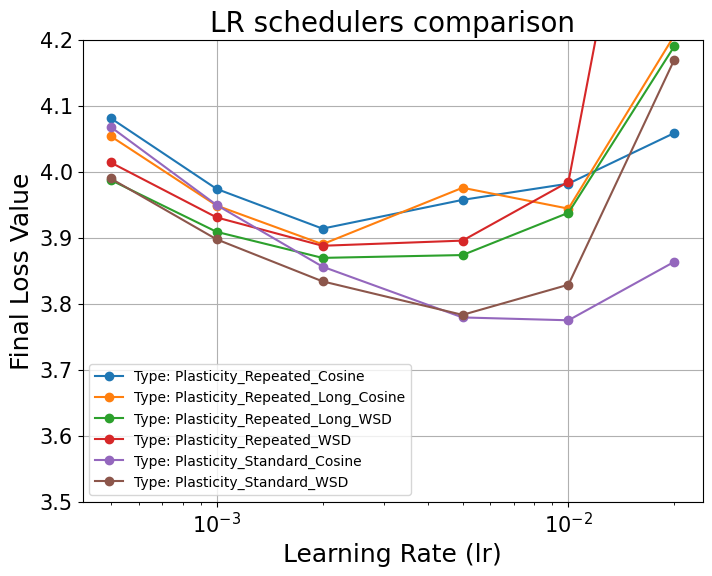

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# tags = ["muP_MoE", "muTransfer", "lr_grid_dense_fixed", "with_mup"]
tags = ["plasticity", "scheduler_comparison"]

df = get_neptune_table(tags)
print(df.shape)
plot_loss_vs_lr(df, (3.5, 4.2), figsize=(6, 6), title="LR schedulers comparison", ax=axes, main_varible='job_config/infrastructure/metric_logger/name', ax_labels_font=18, tick_font=15, title_font=20)

In [6]:
# Diagnostic: Check what columns are available for the new repo
tags = ["plasticity", "scheduler_comparison"]
df_diagnostic = get_neptune_table(tags, print_columns=True)
print("\n=== Sample data from first row ===")
print(df_diagnostic.iloc[0])

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (42, 1078)

=== Available columns ===
  exp_lr
  job/CONDA_EXE
  job/CUDA_DEVICE_ORDER
  job/CUDA_MODULE_LOADING
  job/CUDA_VISIBLE_DEVICES
  job/HOME
  job/HOSTNAME
  job/LOCAL_RANK
  job/LOGNAME
  job/MASTER_ADDR
  job/MASTER_PORT
  job/PATH
  job/RANK
  job/SLURMD_NODENAME
  job/SLURM_ARRAY_JOB_ID
  job/SLURM_ARRAY_TASK_COUNT
  job/SLURM_ARRAY_TASK_ID
  job/SLURM_ARRAY_TASK_STEP
  job/SLURM_CLUSTER_NAME
  job/SLURM_CONF
  job/SLURM_CPUS_ON_NODE
  job/SLURM_GPUS_ON_NODE
  job/SLURM_JOBID
  job/SLURM_JOB_ACCOUNT
  job/SLURM_JOB_CPUS_PER_NODE
  job/SLURM_JOB_END_TIME
  job/SLURM_JOB_GID
  job/SLURM_JOB_GPUS
  job/SLURM_JOB_ID
  job/SLURM_JOB_NAME
  job/SLURM_JOB_PARTITION
  job/SLURM_JOB_START_TIME
  job/SLURM_JOB_UID
  job/SLURM_JOB_USER
  job/SLURM_LOCALID
  job/SLURM_MEM_PER_GPU
  job/SLURM_NODELIST
  job/SLURM_NPROCS
  job/SLURM_SUBMIT_DIR
  job/SLURM_TASKS_PE

## top-k Attention

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/tml-bgw/


Table downloaded
Shape: (21, 872)
(21, 872)


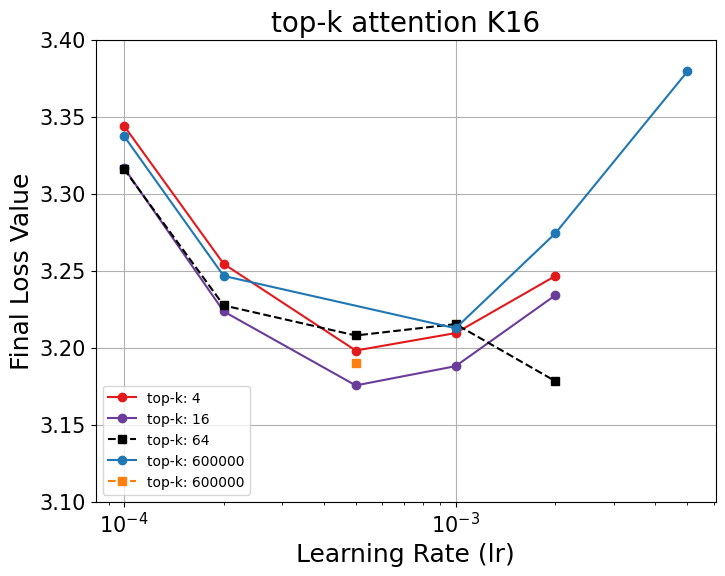

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# tags = ["muP_MoE", "muTransfer", "lr_grid_dense_fixed", "with_mup"]
tags = ["top_k_attention", "n_layers=16"]
negative_tags = ["unfinished"]

df = get_neptune_table(tags, negative_tags=negative_tags, project="pmtest/tml-bgw")
print(df.shape)
plot_loss_vs_lr(df, (3.1, 3.4), figsize=(6, 6), title="top-k attention K16", ax=axes, main_varible='job_config/model/encoder/block_fn/attention_fn/top_k', ax_labels_font=18, tick_font=15, title_font=20)